This notebook demonstrates how to use sensitivity analysis with time series. Time series data has an additional dimension (time) that needs to be handled. This increases the amount of data being worked with substantially. 

The first step is to import all the required libraries.

In [1]:
import pandas as pd
import numpy as np

import scipy.stats

#make sure this test is repeatable
np.random.seed(0)

from matplotlib import pyplot as plt

from IPython.display import display
import attrs

import gumps.apps.monte_carlo_timeseries
import gumps.solvers.monte_carlo_timeseries_solver
import gumps.kernels.kernel
import gumps.kernels.time_kernel
import gumps.apps.monte_carlo_timeseries

from gumps.common.parallel import MultiprocessParallel
from gumps.studies.batch_time_study import BatchTimeStudyMultiProcess

from gumps.studies.study import SimulationStudy
from gumps.solvers.iterative_solver import IterativeSolver, IterativeSolverParameters

%matplotlib inline

Create a kernel for our problem. This will be a combination of sin and cos.

In [2]:
@attrs.define
class SimpleState:
    time:float
    a:float
    b:float
    c:float
    c1:float = 0.0
    c2:float = 0.0
    c3:float = 0.0

class SimpleKernel(gumps.kernels.kernel.AbstractKernel):
    "create an example kernel that returns a time-series"

    def initialize(self):
        "This is where you initialize anything expensive (such as a neural network)"


    def user_defined_function(self, variables: SimpleState) -> None:
        "compute the function"
        variables.c1 = variables.a * np.sin(variables.time) + variables.c
        variables.c2 = variables.b * np.cos(variables.time) + variables.c
        variables.c3 = variables.a * np.sin(variables.time) * variables.b * np.cos(variables.time) + variables.c
        

    def get_state_class(self) -> SimpleState:
        "return the class that holds the state"
        return SimpleState

Next create a solver for this kernel. In this case a simpler iterative solver will do the job.

In [3]:
problem = {'a' : 1,'b' : 1 , 'c' : 0.5, 'time':0}

solver_settings = IterativeSolverParameters(time_start=0, time_end=10, time_points=100)
solver = IterativeSolver(problem=problem, solver_settings=solver_settings)

Next create a study that combines the kernel and solver.

In [4]:
model_variables = {'names':['a', 'b', 'c']}

kernel = SimpleKernel(model_variables=model_variables)

study = SimulationStudy(kernel=kernel, solver=solver)

Next lets run the study and see what it looks like.

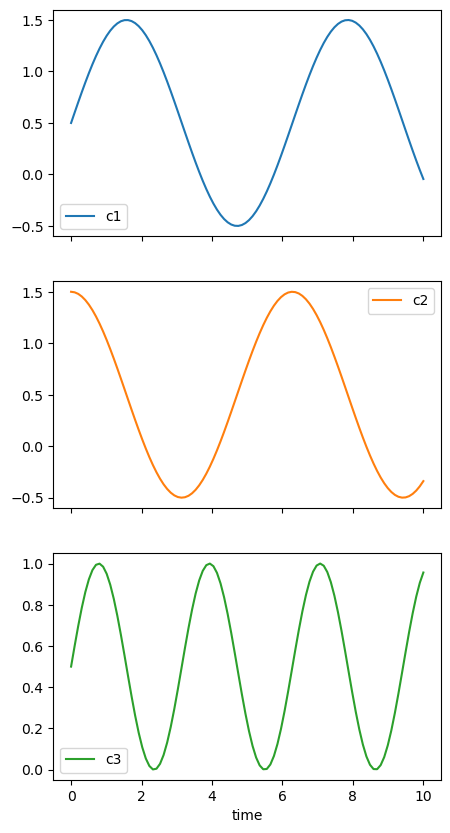

In [5]:
study.run()

df = study.state_frame()

df.plot(x='time', y=['c1', 'c2', 'c3'], subplots=True, figsize=[5,10])
plt.show()

Next we need to convert this to a batch study so it can be run by the UQ code. We have to create a new study here and use a kernel defined in Python. This has to do with a limitation with Jupyter notebooks and Python multiprocessing.

In [6]:
parallel = MultiprocessParallel(poolsize=4)

model_variables = {'names':['a', 'b', 'c']}

kernel = gumps.kernels.time_kernel.SimpleJupyterTimeKernel(model_variables=model_variables)

study = SimulationStudy(kernel=kernel, solver=solver)

batch = BatchTimeStudyMultiProcess(study=study, parallel=parallel)

Next we need to setup the UQ problem. It is important that the target probabilities are not too extreme. While the UQ code will work and eventually finish it may take a very long time to run.

On average if you want to resolve a 1 in 1 million probability the simulation will have to be run 3 - 5 million times. Considering how slow some of the models are this can take a very long time.

In [7]:
distributions = {'a':scipy.stats.uniform(0.9, 1.1),
                'b':scipy.stats.norm(1, 1e-1),
                'c':scipy.stats.uniform(0.5, 1.5)}

def processing_function(data:pd.DataFrame) -> pd.DataFrame:
    "convert the index to the time column"
    df = data[['time', 'c1', 'c2', 'c3']]
    return df.set_index('time')

parameters = gumps.solvers.monte_carlo_timeseries_solver.MonteCarloParameters(variable_distributions=distributions,
                                                                                target_probability=[0.1, 0.5, 0.9],
                                                                                window=2,
                                                                                tolerance=1e-2,
                                                                                min_steps=2,
                                                                                sampler_seed=0,
                                                                                sampler_scramble=False)

app = gumps.apps.monte_carlo_timeseries.MonteCarloTimeSeriesApp(parameters=parameters,
            processing_function=processing_function,
            directory=None,
            batch=batch)

The next step is to run the UQ. This will take a few minutes to run.

In [8]:
app.run()

Now lets look at the results. The data is stored as an xarray array and is useful for processing but is hard to just show the numbers for.

In [9]:
answer = app.answer()

print(answer)

<xarray.Dataset>
Dimensions:   (time: 100, quantile: 3)
Coordinates:
  * time      (time) float64 0.0 0.101 0.202 0.303 ... 9.697 9.798 9.899 10.0
  * quantile  (quantile) float64 0.1 0.5 0.9
Data variables:
    c1        (quantile, time) float64 0.6541 0.8025 0.923 ... 1.322 1.205 1.065
    c2        (quantile, time) float64 1.646 1.641 1.625 ... 0.9451 0.9928
    c3        (quantile, time) float64 0.6541 0.8059 0.9074 ... 2.423 2.512


Lets look at just one result as a table to get an idea of how that works.

In [10]:
result_c1 = pd.DataFrame({'time':answer.time, 
                          'c1_0.1':answer.c1.sel(quantile=0.1).values,
                          'c1_0.5':answer.c1.sel(quantile=0.5).values,
                          'c1_0.9':answer.c1.sel(quantile=0.9).values})

display(result_c1.T)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
time,0.000000,0.101010,0.202020,0.303030,0.404040,0.505051,0.606061,0.707071,0.808081,0.909091,...,9.090909,9.191919,9.292929,9.393939,9.494949,9.595960,9.696970,9.797980,9.898990,10.000000
c1_0.1,0.654124,0.802501,0.923032,1.068401,1.200659,1.321702,1.427487,1.533824,1.610621,1.695002,...,1.111481,0.968274,0.846562,0.699040,0.558469,0.401509,0.260754,0.134309,-0.005444,-0.163777
c1_0.5,1.247076,1.395537,1.527316,1.663618,1.815731,1.954601,2.081593,2.195445,2.303866,2.399084,...,1.709664,1.563551,1.439212,1.292777,1.143156,1.005200,0.851288,0.714782,0.583663,0.452014
c1_0.9,1.845291,1.994444,2.129569,2.266358,2.415257,2.558153,2.696503,2.830342,2.935559,3.051186,...,2.308660,2.172358,2.029792,1.886653,1.741602,1.591566,1.448086,1.321678,1.204692,1.065208


Lets visualize the results.

/home/wheymann/mambaforge/envs/gumps_gpu_311/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


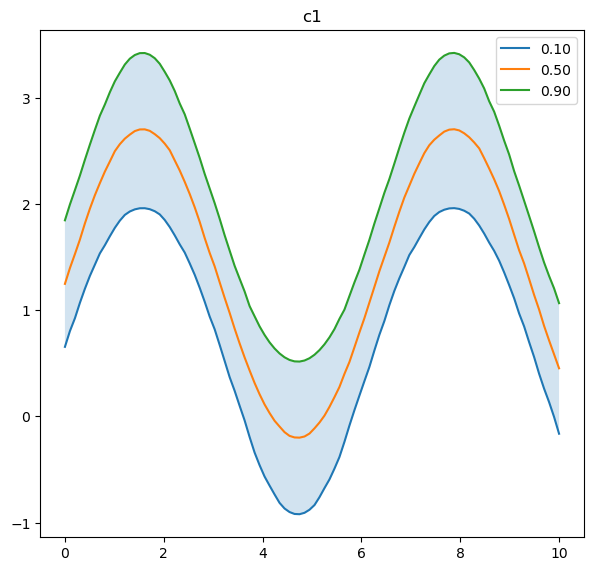

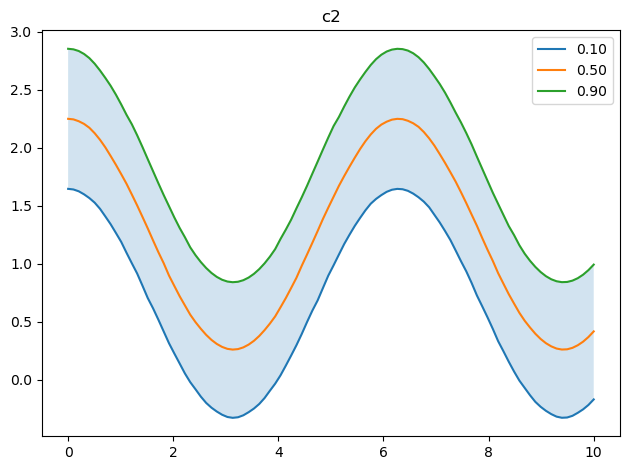

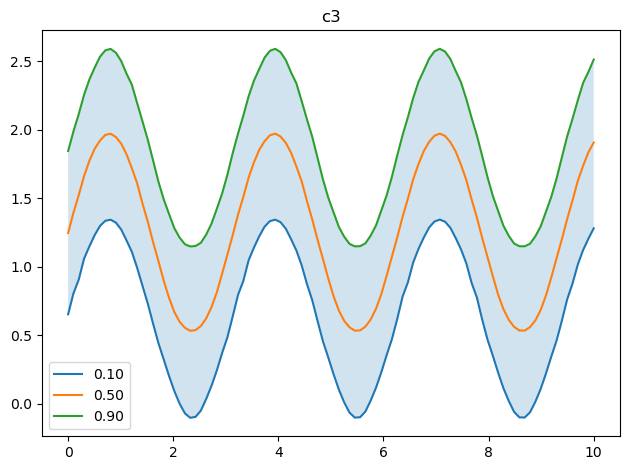

<Figure size 640x480 with 0 Axes>

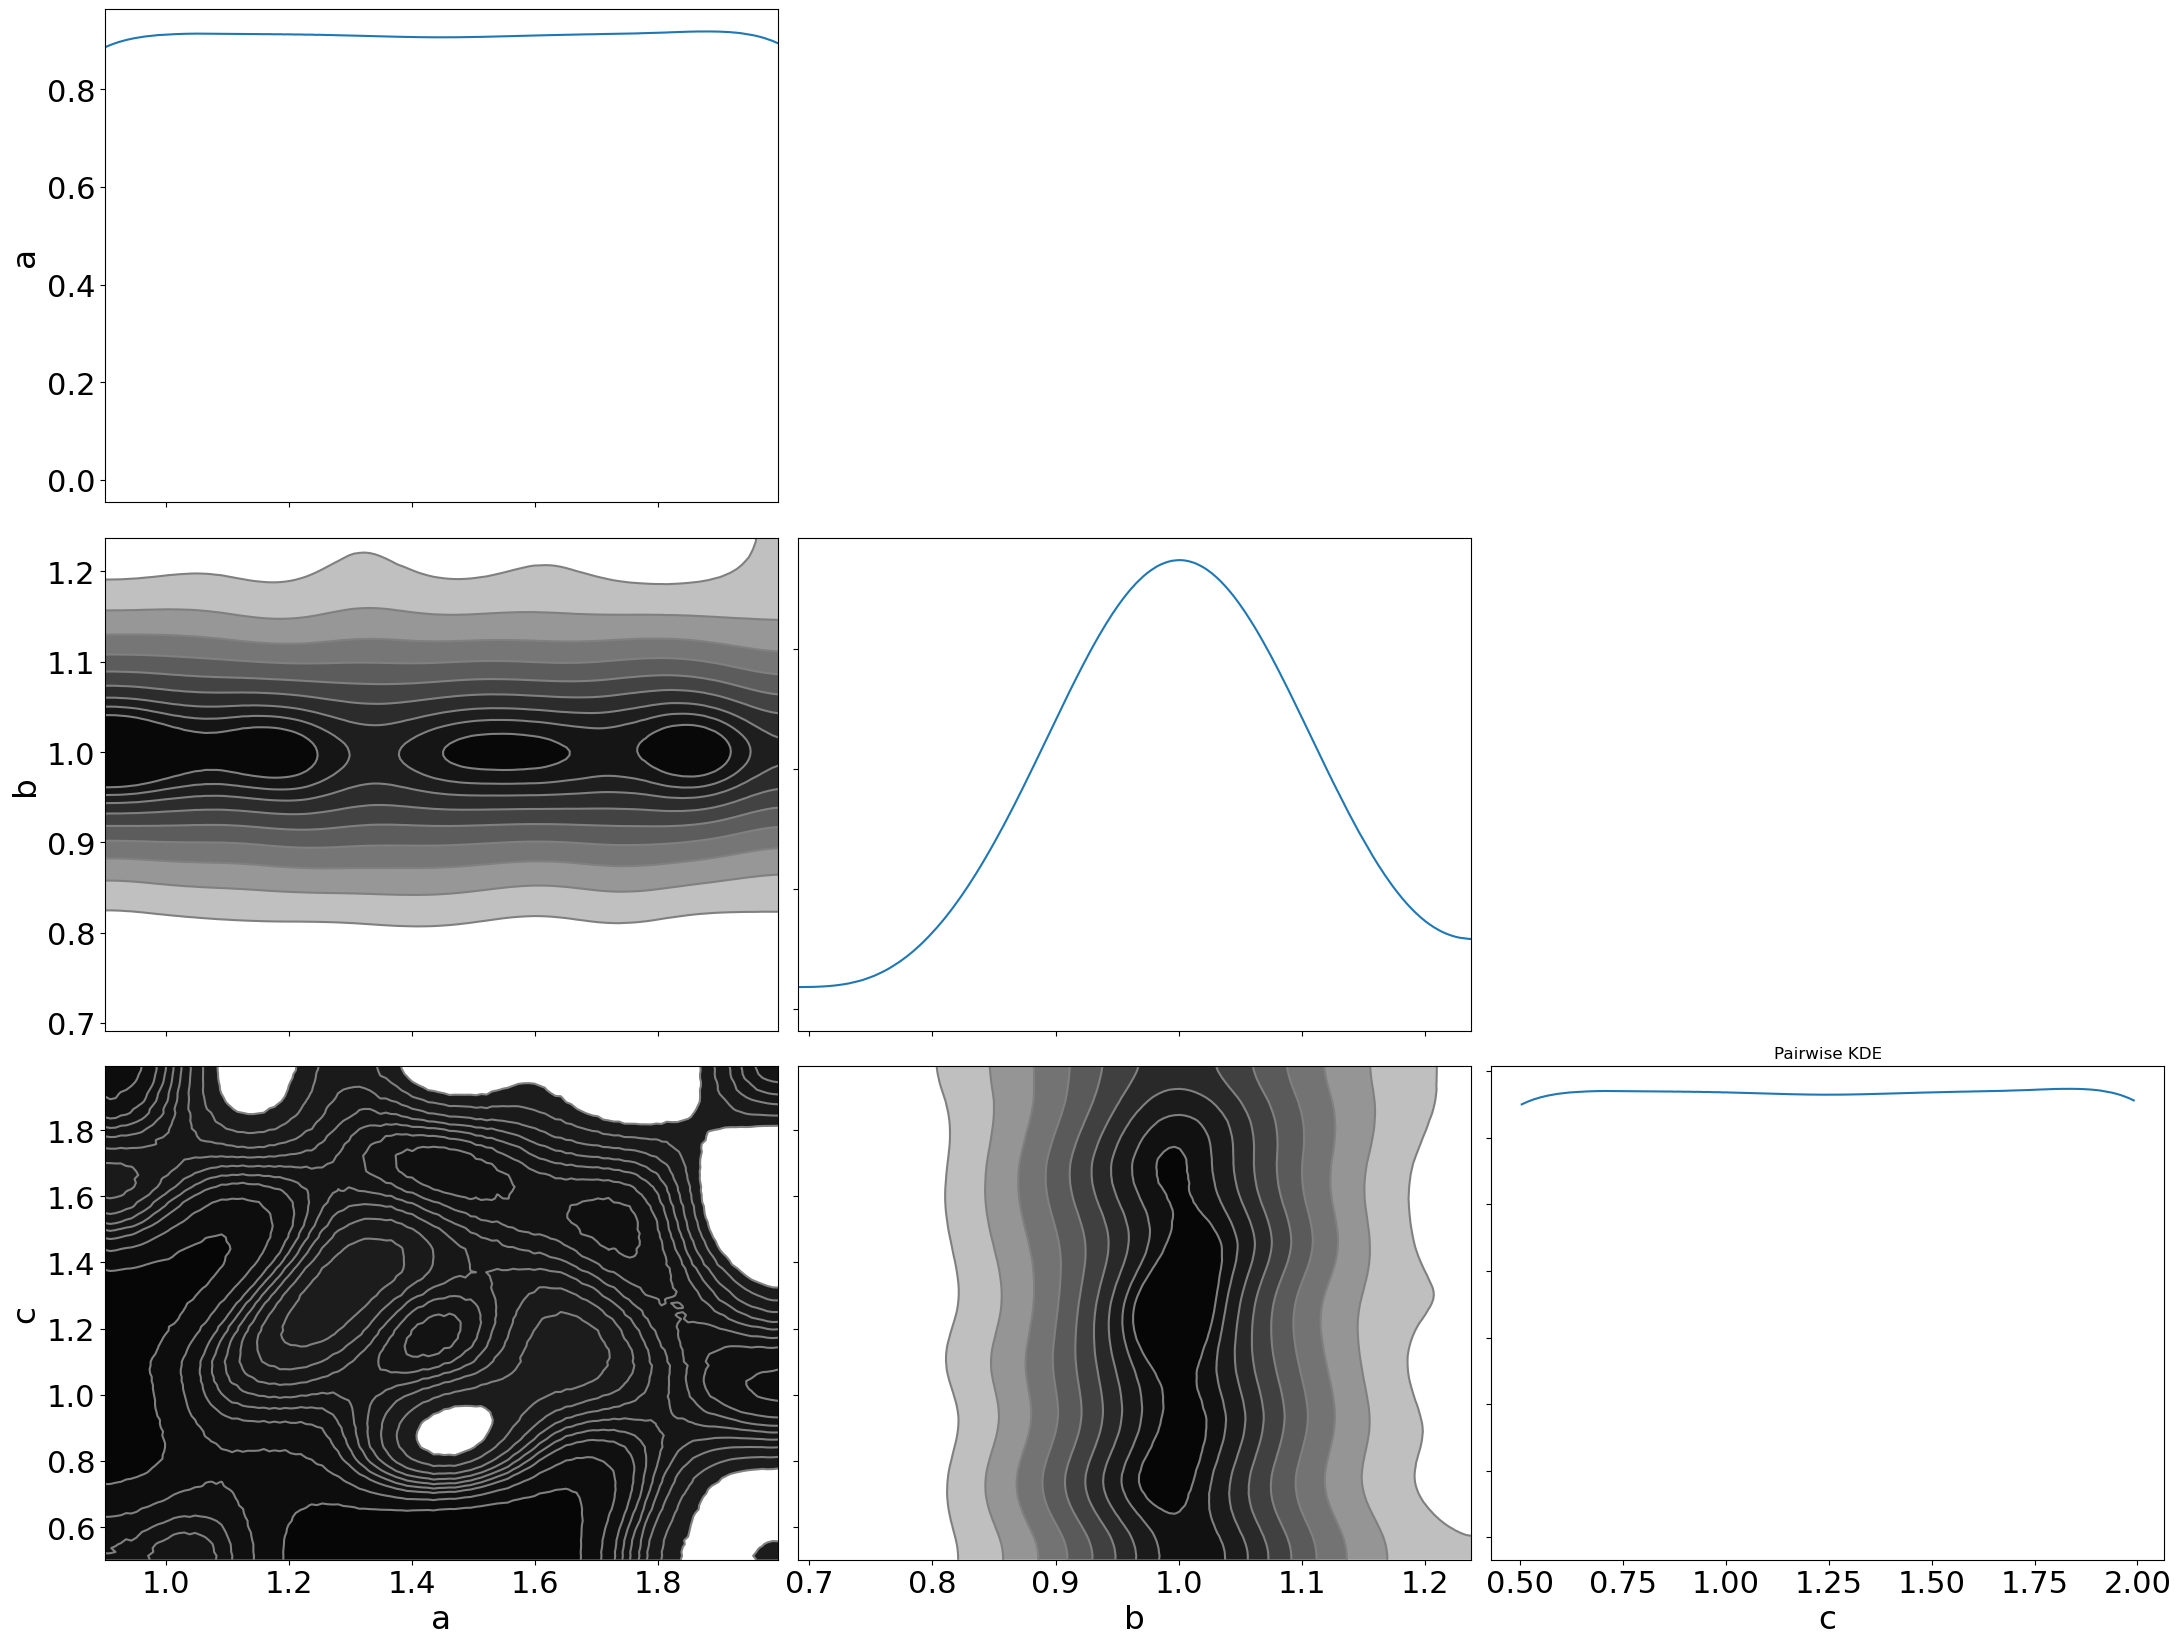

In [11]:
plots = app.get_plots()

for key, fig in plots.items():
    fig.set_size_inches(6, 6)
    plt.show()
    plt.close(fig)